In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [5]:
import keras

print("Keras version:", keras.__version__)

Keras version: 3.10.0


In [20]:
from typing import Literal


def get_running_environment() -> Literal['local', 'colab', 'kaggle', 'marimo', 'jupyter']:
    """
    Returns the current running environment.
    """
    if 'COLAB_GPU' in os.environ:
        return 'colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'kaggle'
    elif 'MARIMO' in os.environ:
        return 'marimo'
    elif 'JUPYTERHUB_USER' in os.environ:
        return 'jupyter'
    else:
        return 'local'
current_env = get_running_environment()

def get_data_path(running_env: str) -> str:
    """
    Returns the path to the data directory based on the running environment.
    """
    if running_env == 'colab':
        return '/content/data'
    elif running_env == 'kaggle':
        return '/kaggle/input/histopathologic-cancer-detection'
    elif running_env == 'marimo':
        return '/data'
    else:
        return './data'

data_dir = get_data_path(current_env)
print(f"Data path: {data_dir} (for {current_env} environment)")

# show list of files in the data directory
if os.path.exists(data_dir):
    files = os.listdir(data_dir)
    print("Files in data directory:")
    for file in files:
        # print file name and being file or folder
        print(f"- {file} | {'Directory' if os.path.isdir(os.path.join(data_dir, file)) else 'File'}")
else:
    raise FileNotFoundError(f"Data directory '{data_dir}' does not exist. Make sure to set up the data path correctly based on the running environment ('{current_env}').")

dataset = {
    'data_dir': data_dir,
    'train_image_dir': os.path.join(data_dir, 'train'),
    'test_image_dir': os.path.join(data_dir, 'test'),
    'sample_submission_file': os.path.join(data_dir, 'sample_submission.csv'),
    'train_labels_file': os.path.join(data_dir, 'train_labels.csv')
}



Data path: ./data (for local environment)
Files in data directory:
- train_labels.csv | File
- .DS_Store | File
- test | Directory
- train | Directory
- sample_submission.csv | File


## Exploratory Data Analysis (EDA)

In [21]:
train_df = pd.read_csv(dataset['train_labels_file'])
print("Train DataFrame shape:", train_df.shape)
print("Train DataFrame columns:", train_df.columns.tolist())
train_df.head()

Train DataFrame shape: (220025, 2)
Train DataFrame columns: ['id', 'label']


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Showing random image from: ./data/train/489d2a912f0c12a6a3da0d1a5eeae854e57a72d9.tif


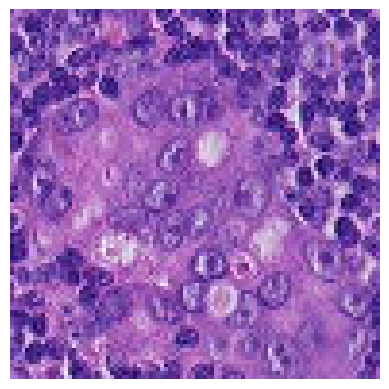

In [ ]:
# show random image from the train directory
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_random_image_from_train():
    image_path = os.path.join(dataset['train_image_dir'], random.choice(train_df['id'].tolist()) + '.tif')
    print(f"Showing random image from: {image_path}")
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_random_image_from_train()